In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np

import crflux.models as pm
import mceq_underground_helpers_cs as mh

In [11]:
plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [12]:
# Load the pickle file
#default order: (str(d), str(cs_p1), str(cs_p2), str(cs_k2), str(ptype), season, str(e0))
with open("/hetghome/khymon/cs-files/R_value_const_pi-air_k-air_sibyll23c_smooth_oneregion_threshold.pkl", "rb") as file:
    data = pickle.load(file)

# Print or inspect the data
print(data)

{('1.5', '0.99', '1.0', '2212', 'jan', '2.05'): array([0.92989719, 0.93080449, 0.93359636]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.15'): array([0.92989719, 0.93080449, 0.93359636]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.25'): array([0.92989719, 0.93080449, 0.93359636]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.35'): array([0.92989719, 0.93080449, 0.93359636]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.45'): array([0.92989716, 0.93080439, 0.93359616]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.55'): array([0.92989718, 0.9308045 , 0.93359644]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.65'): array([0.92988224, 0.93075127, 0.93349627]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.75'): array([0.92980698, 0.93049751, 0.9330405 ]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.85'): array([0.92952284, 0.92994391, 0.93220118]), ('1.5', '0.99', '1.0', '2212', 'jan', '2.95'): array([0.92896269, 0.92919382, 0.93123345]), ('1.5', '0.99', '1.0', '2212', 'jan', '3.05'): array([0.92828203, 0.92846415, 0

In [13]:
e0_values = [2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95]
angles = mh.angles

In [14]:
def dRdE(e0_values,R_array):
    
    slope =np.ndarray(shape=((len(e0_values)-1),3)) 

    for i in range(len(e0_values)-1):
        R1 = R_array[i]
        R2 = R_array[i+1]
        e1 = 10** e0_values[i]
        e2 = 10**e0_values[i+1]
        slope[i] = (R2-R1)/(e2-e1)

    return slope

In [15]:
#get correct energies from MCEq

from MCEq.core import MCEqRun

mceq= MCEqRun(
        interaction_model="SIBYLL23c",
        theta_deg=0.0,
        primary_model=(pm.HillasGaisser2012, "H3a"),
        density_model = (('MSIS00_IC',('SouthPole','January')))
)

e_mceq = mceq.e_bins

# array mask - e0 is set to first mceq energy bin at higher energues, eg 1000 -> 1122

MCEqRun::set_interaction_model(): SIBYLL23C


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [16]:
def get_data(fixed_params):
    # Define the e0_values list to iterate over
    e0_values_list = ['2.05', '2.15', '2.25', '2.35', '2.45', '2.55', '2.65', '2.75', '2.85', '2.95', 
                      '3.05', '3.15', '3.25', '3.35', '3.45', '3.55', '3.65', '3.75', '3.85', '3.95', 
                      '4.05', '4.15', '4.25', '4.35', '4.45', '4.55', '4.65', '4.75', '4.85', '4.95']
    
    # Collect data for each e0_value
    sel_data = [data[(fixed_params[0], fixed_params[1], "1.0", "2212", "apr", e0)] for e0 in e0_values_list]

    return np.array(sel_data)

In [17]:
data_15_csp099 = get_data(("1.5", "0.99"))
data_35_csp099 = get_data(("3.5", "0.99"))

data_15_csp101 = get_data(("1.5", "1.01"))
data_35_csp101 = get_data(("3.5", "1.01"))


In [18]:
s_15_cs099 = dRdE(e0_values,data_15_csp099)
s_35_cs099 = dRdE(e0_values,data_35_csp099)
s_15_cs101 = dRdE(e0_values,data_15_csp101)
s_35_cs101 = dRdE(e0_values,data_35_csp101)

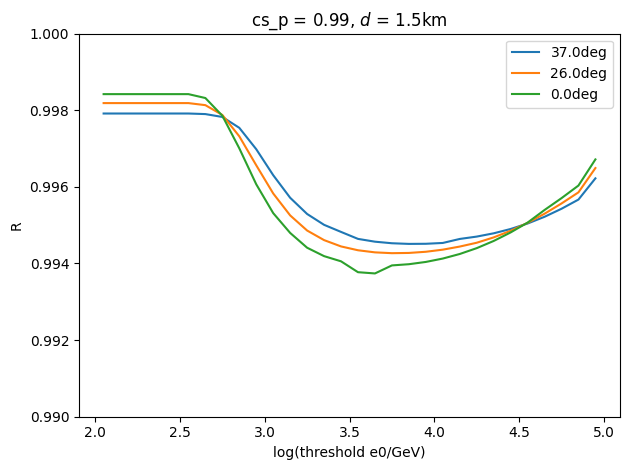

In [29]:
for j in range(len(s_15_cs099[0])):
    plt.plot(e0_values, data_15_csp099[:,j],label=str(np.round(angles[j],decimals=0)) + 'deg')


plt.xlabel('log(threshold e0/GeV)')
plt.ylabel('R')
plt.title('cs_p = 0.99, $d$ = 1.5km')
plt.ylim(0.99,1.)
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'e0_R_csp0.99_depth1.5.png')

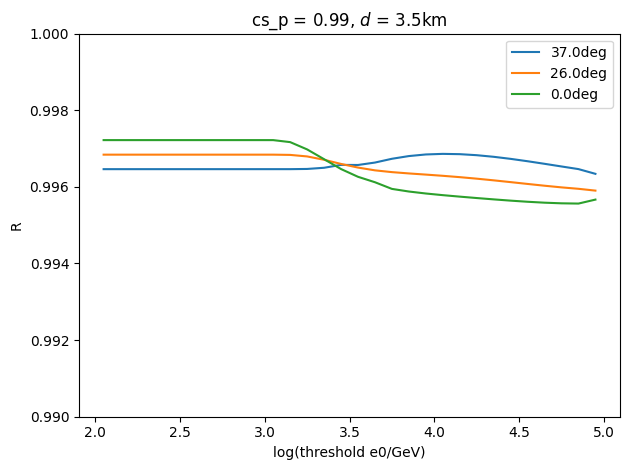

In [28]:
for j in range(len(s_35_cs099[0])):
    plt.plot(e0_values, data_35_csp099[:,j],label=str(np.round(angles[j],decimals=0)) + 'deg')


plt.xlabel('log(threshold e0/GeV)')
plt.ylabel('R')
plt.title('cs_p = 0.99, $d$ = 3.5km')
plt.legend()
plt.ylim(0.99,1.0)
plt.tight_layout()
plt.savefig(plot_dir + 'e0_R_csp0.99_depth3.5.png')

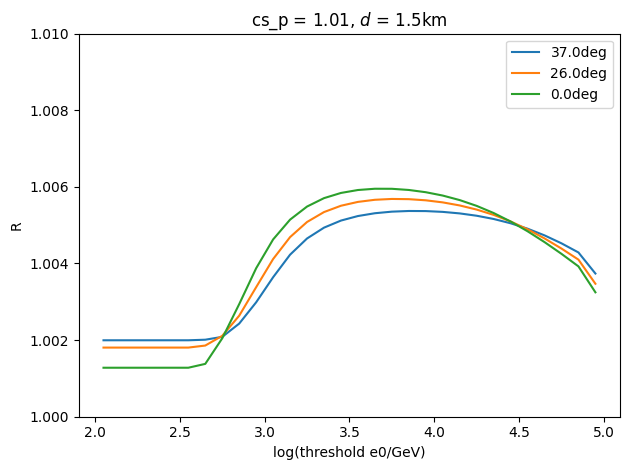

In [27]:
for j in range(len(s_15_cs099[0])):
    plt.plot(e0_values, data_15_csp101[:,j],label=str(np.round(angles[j],decimals=0)) + 'deg')


plt.xlabel('log(threshold e0/GeV)')
plt.ylabel('R')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.legend()
plt.tight_layout()
plt.ylim(1.,1.01)
plt.savefig(plot_dir + 'e0_R_csp101_depth1.5.png')

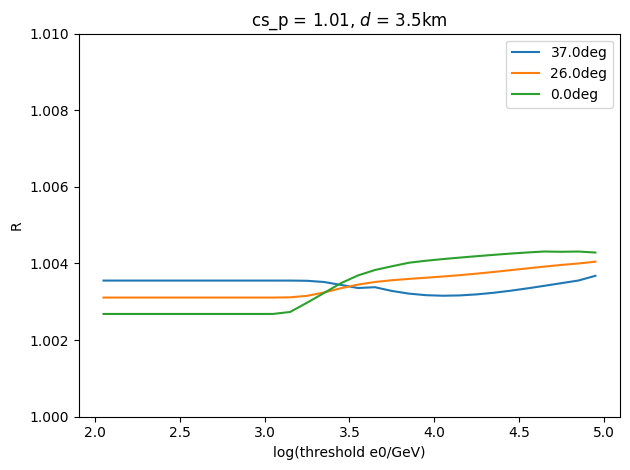

In [30]:
for j in range(len(s_15_cs099[0])):
    plt.plot(e0_values, data_35_csp101[:,j],label=str(np.round(angles[j],decimals=0)) + 'deg')


plt.xlabel('log(threshold e0/GeV)')
plt.ylabel('R')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.legend()
plt.ylim(1.,1.01)
plt.tight_layout()
plt.savefig(plot_dir + 'e0_R_csp1.01_depth3.5.png')

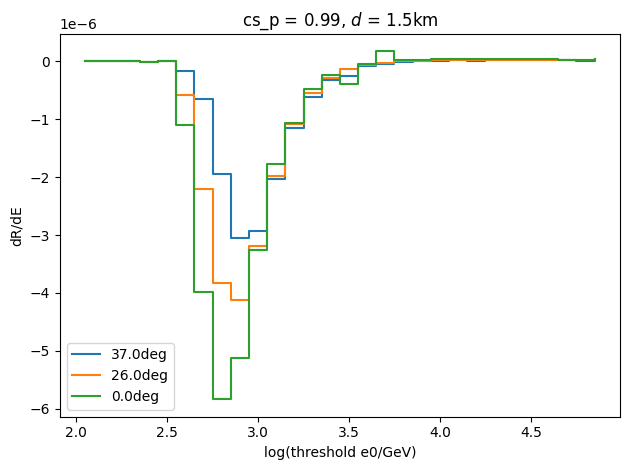

In [23]:
# Plotting the data as a step plot (histogram style)
for j in range(len(angles)):
    plt.plot(e0_values[:-1], s_15_cs099[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 0.99, $d$ = 1.5km')
plt.ylabel('dR/dE')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'dEdR_csp0.99_lin_depth1.5.png')

In [26]:
for j in range(len(angles)):
    plt.plot(e0_values[:-1], s_35_cs099[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 0.99, $d$ = 3.5km')
plt.ylabel('dR/dE')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'dEdR_csp0.99_lin_depth3.5.png')
plt.clf()

for j in range(len(angles)):
    plt.plot(e0_values[:-1], s_15_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.ylabel('dR/dE')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'dEdR_csp1.01_lin_depth1.5.png')
plt.clf()

for j in range(len(angles)):
    plt.plot(e0_values[:-1], s_35_cs101[:,j], drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dR/dE')
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir + 'dEdR_csp1.01_lin_depth3.5.png')
plt.clf()

<Figure size 640x480 with 0 Axes>

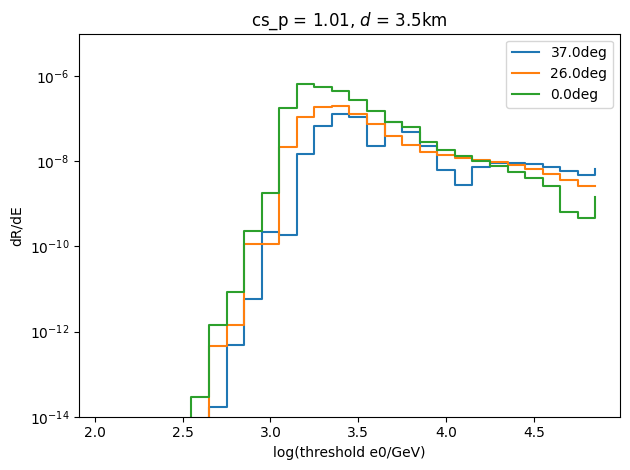

In [25]:
# Plotting the data as a step plot (histogram style)
for j in range(len(angles)):
    plt.plot(e0_values[:-1], np.abs(s_15_cs099[:,j]), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 0.99, $d$ = 1.5km')
plt.ylabel('dR/dE')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.ylim(1e-14,1e-5)
plt.savefig(plot_dir + 'dEdR_csp0.99_absolute_log_depth1.5.png')
plt.clf()

for j in range(len(angles)):
    plt.plot(e0_values[:-1], np.abs(s_35_cs099[:,j]), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 0.99, $d$ = 3.5km')
plt.ylabel('dR/dE')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.ylim(1e-14,1e-5)
plt.savefig(plot_dir + 'dEdR_csp0.99_absolute_log_depth3.5.png')
plt.clf()

for j in range(len(angles)):
    plt.plot(e0_values[:-1], np.abs(s_15_cs101[:,j]), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 1.5km')
plt.ylabel('dR/dE')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.ylim(1e-14,1e-5)
plt.savefig(plot_dir + 'dEdR_csp1.01_absolute_log_depth1.5.png')
plt.clf()

for j in range(len(angles)):
    plt.plot(e0_values[:-1], np.abs(s_35_cs101[:,j]), drawstyle='steps-post',label=str(np.round(angles[j],decimals=0)) + 'deg')

# Add labels and title
plt.xlabel('log(threshold e0/GeV)')
plt.title('cs_p = 1.01, $d$ = 3.5km')
plt.ylabel('dR/dE')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.ylim(1e-14,1e-5)
plt.savefig(plot_dir + 'dEdR_csp1.01_absolute_log_depth3.5.png')
